#### 7/14/25 - Past Month Weather Data and Map Creation     
By: Angel Moreno

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import glob

#### Getting the weather data:

Using https://open-meteo.com/en/docs?past_days=31 api endpoint.

In [2]:
# tracts = gpd.read_file("Tiger_Illinois_Tracts_2020.zip")  

chicago_tracts = gpd.read_file("Chicago_Tracts_2020.zip")
chicago_tracts_proj = chicago_tracts.to_crs("EPSG:26916")

chicago_tracts_proj['centroid'] = chicago_tracts_proj.geometry.centroid
centroids_geo = chicago_tracts_proj['centroid'].to_crs(epsg=4326)

chicago_tracts['latitude'] = centroids_geo.y
chicago_tracts['longitude'] = centroids_geo.x

chicago_tracts.shape

(878, 21)

Before moving forward to the api calls I need to double check the data types (this was giving me trouble).

In [3]:
chicago_tracts.dtypes

objectid             float64
census_tra            object
census_t_1            object
tract_fips            object
tract_cent           float64
tract_ce_1           float64
tract_ce_2           float64
tract_ce_3           float64
tract_comm            object
tract_numa           float64
tract_cens           float64
perimeter            float64
data_admin           float64
tract_crea            object
date_tract    datetime64[ms]
time_tract            object
shape_area           float64
shape_len            float64
geometry            geometry
latitude             float64
longitude            float64
dtype: object

In [4]:
chicago_tracts.rename(columns={"census_t_1":"tract_id"}, inplace=True)
chicago_tracts["tract_id"] = chicago_tracts["tract_id"].astype(np.int64)

In [5]:
chicago_tracts.dtypes

objectid             float64
census_tra            object
tract_id               int64
tract_fips            object
tract_cent           float64
tract_ce_1           float64
tract_ce_2           float64
tract_ce_3           float64
tract_comm            object
tract_numa           float64
tract_cens           float64
perimeter            float64
data_admin           float64
tract_crea            object
date_tract    datetime64[ms]
time_tract            object
shape_area           float64
shape_len            float64
geometry            geometry
latitude             float64
longitude            float64
dtype: object

In [6]:
chicago_tracts.isna().sum()

objectid        0
census_tra      0
tract_id        0
tract_fips      0
tract_cent      0
tract_ce_1      0
tract_ce_2      0
tract_ce_3      0
tract_comm      0
tract_numa      0
tract_cens      0
perimeter       0
data_admin      0
tract_crea    878
date_tract    878
time_tract    878
shape_area      0
shape_len       0
geometry        0
latitude        0
longitude       0
dtype: int64

In [7]:
outside_bounds = chicago_tracts[
    (chicago_tracts["latitude"] < 41.5) | 
    (chicago_tracts["latitude"] > 42.1) | 
    (chicago_tracts["longitude"] > -87.5) | 
    (chicago_tracts["longitude"] < -88.1)
]
print(f"Outside Chicago bounds: {len(outside_bounds)}")


Outside Chicago bounds: 0


In [8]:
# for testing
# chicago_tracts = chicago_tracts.sample(10)
# chicago_tracts.tract_id.nunique()
chicago_tracts.shape

(878, 21)

In [9]:
def fetch_tract_weather(row, save_dir="weather_data"):
    '''Script to get past month weather data for each tract in Chicago as per the 2020 Census data. \nReturns a dataframe. '''
    
    lat = row["latitude"]
    lon = row["longitude"]
    
    tract_id = row["tract_id"] # this is the tract identifier
    filename = os.path.join(save_dir, f"tract_weather_{tract_id}.parquet") # caching

    if os.path.exists(filename):
        try:
            return pd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read existing data for tract {tract_id}: {e}")

    api_params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["temperature_180m", "wind_direction_180m", "wind_speed_180m", "surface_pressure", "cloud_cover", "relative_humidity_2m", "precipitation", "visibility"],
        "timezone": "America/Chicago",
        "past_days": 30, 
        "forecast_days": 0,
        "wind_speed_unit": "mph",
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch"
    }

    api = "https://api.open-meteo.com/v1/forecast"  

    try:
        time.sleep(0.1)
        response = requests.get(api, params=api_params, timeout=15)
        response.raise_for_status()
        data = response.json()

        if "hourly" not in data:
            raise ValueError(f"No 'hourly' key found: {data}")

        hourly_data = pd.DataFrame(data["hourly"])
        hourly_data["tract_id"] = tract_id

        os.makedirs(save_dir, exist_ok=True)
        hourly_data.to_parquet(filename, index=False)

        return hourly_data

    except Exception as e:
        print(f"Failed for tract {row['tract_id']} at ({lat}, {lon}): {e}")
        return None

In [10]:
def all_tracts_weather():
    '''Get past month weather data for each Chicago tract (2020).'''
    final_csv_data = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(fetch_tract_weather, row) for _, row in chicago_tracts.iterrows()]
        
        # tdqm progress bar 
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching weather data"):
            result = future.result()
            if result is not None:
                final_csv_data.append(result)

    all_tracts_csv = pd.concat(final_csv_data, ignore_index=True)
    return all_tracts_csv

3-5 minute expected runtime for the full 30 day data

In [11]:
final_tracts_weather_csv = all_tracts_weather()
final_tracts_weather_csv

Fetching weather data: 100%|██████████| 878/878 [00:06<00:00, 128.42it/s]


,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id
0,2025-07-14T00:00,73.1,325,8.2,995.0,1,89,0.0,46587.926,17031730200
1,2025-07-14T01:00,71.9,346,4.6,994.8,0,88,0.0,47900.262,17031730200
2,2025-07-14T02:00,71.7,348,4.3,994.6,5,89,0.0,47572.180,17031730200
3,2025-07-14T03:00,71.5,343,3.7,994.6,8,91,0.0,44619.422,17031730200
4,2025-07-14T04:00,71.5,333,3.5,994.5,6,87,0.0,50196.852,17031730200
...,...,...,...,...,...,...,...,...,...,...
625195,2025-07-14T19:00,80.9,266,3.1,995.5,0,59,0.0,101377.953,17031242200
625196,2025-07-14T20:00,80.2,290,3.3,995.4,0,74,0.0,70538.055,17031242200
625197,2025-07-14T21:00,79.0,327,3.7,995.4,0,83,0.0,56430.445,17031242200
625198,2025-07-14T22:00,77.2,353,3.6,995.7,5,81,0.0,59383.203,17031242200


In [12]:
all_files = glob.glob("weather_data/tract_weather_*.parquet")
full_df = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)
full_df

,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id
0,2025-07-14T00:00,73.7,316,6.8,996.4,7,84,0.0,53149.605,17031000000
1,2025-07-14T01:00,71.7,339,1.9,996.2,0,86,0.0,50196.852,17031000000
2,2025-07-14T02:00,71.7,319,2.1,995.9,1,87,0.0,47572.180,17031000000
3,2025-07-14T03:00,71.7,301,2.6,996.1,0,88,0.0,45603.676,17031000000
4,2025-07-14T04:00,71.7,293,3.4,996.0,5,87,0.0,46916.012,17031000000
...,...,...,...,...,...,...,...,...,...,...
625195,2025-07-14T19:00,78.6,264,6.3,993.7,2,49,0.0,128608.922,17031840000
625196,2025-07-14T20:00,77.9,276,6.1,993.4,0,53,0.0,115485.562,17031840000
625197,2025-07-14T21:00,77.7,291,5.5,993.6,0,49,0.0,127296.586,17031840000
625198,2025-07-14T22:00,77.3,298,3.8,993.8,35,59,0.0,92847.773,17031840000


The number of rows above might not match up with the number at the bottom since ther emay be disparities between 

In [13]:
expected_rows_1d = (878 * 24 * 30) # rows * hours * days
expected_rows_1d

632160

In [14]:
num_unique_tracts = full_df['tract_id'].nunique()
print(f"Number of tracts with data: {num_unique_tracts}")

Number of tracts with data: 878


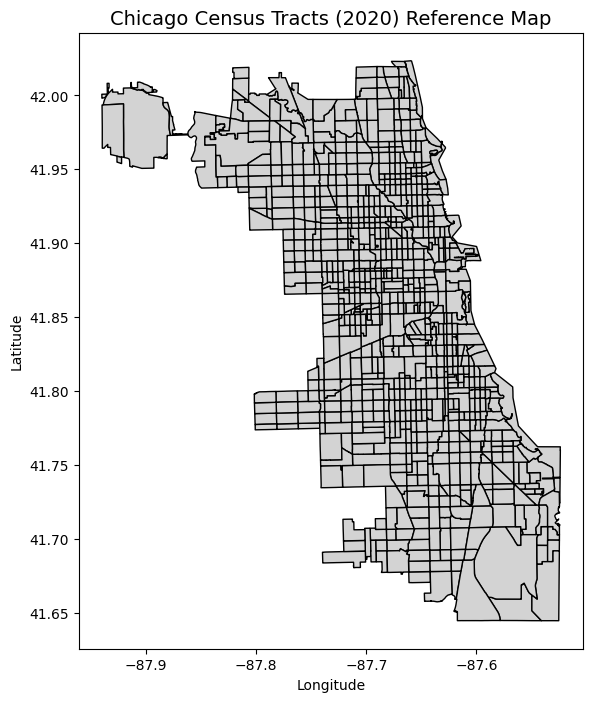

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
chicago_tracts.plot(ax=ax, edgecolor='black', facecolor='lightgray')
ax.set_title("Chicago Census Tracts (2020) Reference Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Cleaning/preparing the data:

In [16]:
full_df["trimmed_time"] = full_df["time"].str.slice(0,10)
full_df["cleaned_time"] = pd.to_datetime(full_df["trimmed_time"])

In [17]:
full_df.groupby("cleaned_time").nunique()
# notice how july 14 2025 has all 878 tracts but the other days do not

,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id,trimmed_time
cleaned_time,,,,,,,,,,,
2025-06-15,24,101,45,110,92,99,51,1,247,868,1
2025-06-16,24,133,99,106,131,100,57,1,332,868,1
2025-06-17,24,166,67,110,100,91,65,1,348,868,1
2025-06-18,24,131,157,174,123,75,43,135,232,868,1
2025-06-19,24,146,64,101,139,95,63,49,334,868,1
2025-06-20,24,91,70,136,111,96,48,2,279,868,1
2025-06-21,24,140,28,125,93,76,40,1,232,868,1
2025-06-22,24,118,24,125,108,58,47,1,265,868,1
2025-06-23,24,121,28,116,103,53,51,1,306,868,1


In [18]:
29*24*868 + 24*878
# 29 days with 24 hour data for 868 tracts + 
# one day with 24 hour data for 878 tracts
# results in 625200 rows which we have 

625200

In [19]:
agg_weather_data = full_df.drop(columns=["time","trimmed_time"]).groupby(["cleaned_time","tract_id"]).agg("mean").reset_index()
agg_weather_data

,cleaned_time,tract_id,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility
0,2025-06-15,17031010100,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208
1,2025-06-15,17031010200,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208
2,2025-06-15,17031010300,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208
3,2025-06-15,17031010400,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208
4,2025-06-15,17031010500,67.400000,66.208333,10.437500,996.666667,24.833333,77.583333,0.0,61871.172208
...,...,...,...,...,...,...,...,...,...,...
26045,2025-07-14,17031811600,74.450000,261.916667,6.162500,994.383333,2.875000,61.916667,0.0,101774.387167
26046,2025-07-14,17031820800,74.687500,276.625000,4.700000,995.829167,0.958333,63.375000,0.0,103619.859042
26047,2025-07-14,17031821500,74.979167,284.000000,4.304167,996.462500,4.791667,68.500000,0.0,89115.814625
26048,2025-07-14,17031823304,74.512500,276.625000,4.700000,994.320833,1.916667,61.458333,0.0,102676.619292


#### Creating the maps:

This map creation will include ~866 tracts since it is using 2020 census data.

In [20]:
## merge weather data with chicago_tracts and keep only relevant columns
df_merged = agg_weather_data.merge(chicago_tracts, on="tract_id", how="inner")
df_merged.shape

(26050, 30)

In [21]:
df_merged = df_merged[['cleaned_time','tract_id', 'cloud_cover', 'visibility',
       'relative_humidity_2m', 'precipitation', 'wind_speed_180m',
       'wind_direction_180m', 'temperature_180m', 'surface_pressure','geometry']]
gdf = gpd.GeoDataFrame(df_merged, geometry="geometry")
print(type(gdf))
print(gdf.crs) # 4326 is the world crs with lat and lon 

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326


In [22]:
# gdf = gdf.to_crs("EPSG:26916")
# gdf = gdf[gdf.area != gdf.area.max()]
# gdf = gdf.to_crs("EPSG:4326")

In [23]:
gdf["tract_id"].nunique()

878

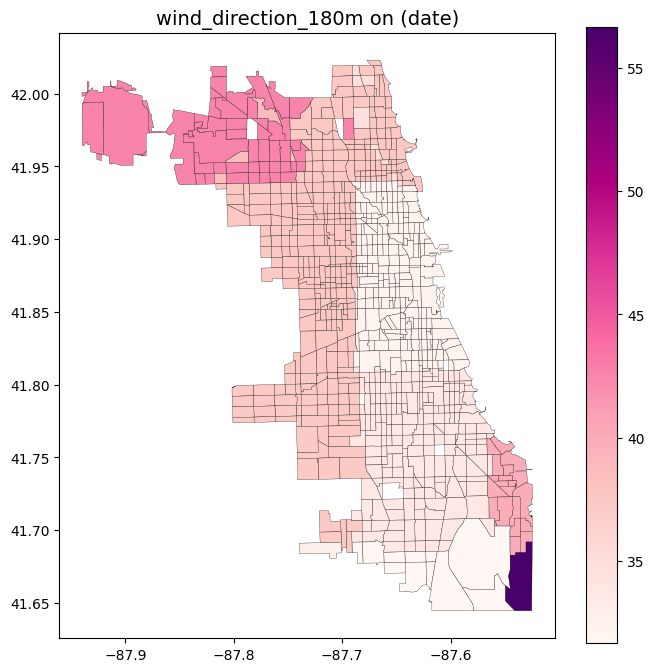

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# for some reason only the day of 2025-07-14 has all tract data
gdf[gdf["cleaned_time"]=="2025-07-07"].plot(
    column="wind_direction_180m",
    cmap="RdPu",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

ax.set_title("wind_direction_180m on (date)", fontsize=14)
plt.show()

In [25]:
gdf.isna().sum()

cleaned_time            0
tract_id                0
cloud_cover             0
visibility              0
relative_humidity_2m    0
precipitation           0
wind_speed_180m         0
wind_direction_180m     0
temperature_180m        0
surface_pressure        0
geometry                0
dtype: int64

#### Historical API switch

7/27/25 - Get June 15th to July 15th parquet for the SHAP based feature selection for bird migration hotspot analysis

In [ ]:
def get_weather_data_2010_tracts(row, save_dir="weather_data", force_update=False):
    '''Script to get past month weather data for each tract in Chicago as per the 2020 Census data. \nReturns a dataframe. '''
    
    lat = row["latitude"]
    lon = row["longitude"]
    
    tract_id = row["tract_id"] # this is the tract identifier
    filename = os.path.join(save_dir, f"tract_weather_{tract_id}.parquet") # caching

    if os.path.exists(filename) and not force_update:
        try:
            return pd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read existing data for tract {tract_id}: {e}")

    api_params = {
        "latitude": lat,
        "longitude": lon,
        "timezone": "America/Chicago",
        "start_date": "2025-06-15",
        "end_date": "2025-07-15",
        "hourly": ["temperature_180m", "wind_direction_180m", "wind_speed_180m", "surface_pressure", "cloud_cover", "relative_humidity_2m", "precipitation", "visibility"],
        "wind_speed_unit": "mph",
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch"
    }

    api = "https://api.open-meteo.com/v1/forecast"  

    try:
        time.sleep(0.1)
        response = requests.get(api, params=api_params, timeout=15)
        response.raise_for_status()
        data = response.json()

        if "hourly" not in data:
            raise ValueError(f"No 'hourly' key found: {data}")

        hourly_data = pd.DataFrame(data["hourly"])
        hourly_data["tract_id"] = tract_id

        os.makedirs(save_dir, exist_ok=True)
        hourly_data.to_parquet(filename, index=False)

        return hourly_data

    except Exception as e:
        print(f"Failed for tract {row['tract_id']} at ({lat}, {lon}): {e}")
        return None

In [45]:
def all_tracts_weather_historical():
    '''Get past month weather data for each Chicago tract (2020).'''
    final_csv_data = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(get_july15th_data, row, force_update=True) for _, row in chicago_tracts.iterrows()]
        
        # tdqm progress bar 
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching weather data"):
            result = future.result()
            if result is not None:
                final_csv_data.append(result)

    all_tracts_csv = pd.concat(final_csv_data, ignore_index=True)
    return all_tracts_csv

In [46]:
final_tracts_weather_csv = all_tracts_weather_historical()
final_tracts_weather_csv

Fetching weather data: 100%|██████████| 878/878 [03:14<00:00,  4.52it/s]


,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id
0,2025-07-15T00:00,77.1,23,3.4,995.4,0,55,0.0,111548.555,17031730200
1,2025-07-15T01:00,76.2,63,1.5,995.3,0,61,0.0,96128.609,17031730200
2,2025-07-15T02:00,75.8,151,2.3,995.7,15,89,0.0,44947.508,17031730200
3,2025-07-15T03:00,75.7,170,3.9,996.1,10,93,0.0,41666.668,17031730200
4,2025-07-15T04:00,75.3,173,5.6,995.8,1,90,0.0,45931.758,17031730200
...,...,...,...,...,...,...,...,...,...,...
21067,2025-07-15T19:00,79.7,118,9.6,991.4,71,59,0.0,97769.031,17031242200
21068,2025-07-15T20:00,80.4,144,11.1,991.1,28,66,0.0,83661.414,17031242200
21069,2025-07-15T21:00,80.6,191,13.0,990.8,8,59,0.0,103018.375,17031242200
21070,2025-07-15T22:00,79.0,203,13.6,991.7,5,71,0.0,75787.398,17031242200


In [38]:
final_tracts_weather_csv["time"].unique()

array(['2025-07-14T00:00', '2025-07-14T01:00', '2025-07-14T02:00',
       '2025-07-14T03:00', '2025-07-14T04:00', '2025-07-14T05:00',
       '2025-07-14T06:00', '2025-07-14T07:00', '2025-07-14T08:00',
       '2025-07-14T09:00', '2025-07-14T10:00', '2025-07-14T11:00',
       '2025-07-14T12:00', '2025-07-14T13:00', '2025-07-14T14:00',
       '2025-07-14T15:00', '2025-07-14T16:00', '2025-07-14T17:00',
       '2025-07-14T18:00', '2025-07-14T19:00', '2025-07-14T20:00',
       '2025-07-14T21:00', '2025-07-14T22:00', '2025-07-14T23:00',
       '2025-06-15T00:00', '2025-06-15T01:00', '2025-06-15T02:00',
       '2025-06-15T03:00', '2025-06-15T04:00', '2025-06-15T05:00',
       '2025-06-15T06:00', '2025-06-15T07:00', '2025-06-15T08:00',
       '2025-06-15T09:00', '2025-06-15T10:00', '2025-06-15T11:00',
       '2025-06-15T12:00', '2025-06-15T13:00', '2025-06-15T14:00',
       '2025-06-15T15:00', '2025-06-15T16:00', '2025-06-15T17:00',
       '2025-06-15T18:00', '2025-06-15T19:00', '2025-06-15T20:

In [39]:
final_tracts_weather_csv["trimmed_time"] = final_tracts_weather_csv["time"].str.slice(0,10)
final_tracts_weather_csv["cleaned_time"] = pd.to_datetime(final_tracts_weather_csv["trimmed_time"])
final_tracts_weather_csv.groupby("cleaned_time").nunique()

,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id,trimmed_time
cleaned_time,,,,,,,,,,,
2025-06-15,24,101,45,110,92,99,51,1,247,868,1
2025-06-16,24,133,99,106,131,100,57,1,332,868,1
2025-06-17,24,166,67,110,100,91,65,1,348,868,1
2025-06-18,24,131,157,174,123,75,43,135,232,868,1
2025-06-19,24,146,64,101,139,95,63,49,334,868,1
2025-06-20,24,91,70,136,111,96,48,2,279,868,1
2025-06-21,24,140,28,125,93,76,40,1,232,868,1
2025-06-22,24,118,24,125,108,58,47,1,265,868,1
2025-06-23,24,121,28,116,103,53,51,1,306,868,1


In [33]:
agg_weather_data = final_tracts_weather_csv.drop(columns=["time","trimmed_time"]).groupby(["cleaned_time","tract_id"]).agg("mean").reset_index()
agg_weather_data
df_merged = agg_weather_data.merge(chicago_tracts, on="tract_id", how="inner")
df_merged.shape

(26050, 30)

#### Getting aggregated weather data for each census tract but for 2010 tracts to maximize rows in SHAP ranking

In [3]:
# same proccess but for 2010 tracts instead
chicago_tracts_2010 = gpd.read_file("Chicago_Tracts_2010.zip")
chicago_tracts_proj = chicago_tracts_2010.to_crs("EPSG:26916")

chicago_tracts_proj['centroid'] = chicago_tracts_proj.geometry.centroid
centroids_geo = chicago_tracts_proj['centroid'].to_crs(epsg=4326)

chicago_tracts_2010['latitude'] = centroids_geo.y
chicago_tracts_2010['longitude'] = centroids_geo.x

chicago_tracts_2010.shape

(801, 12)

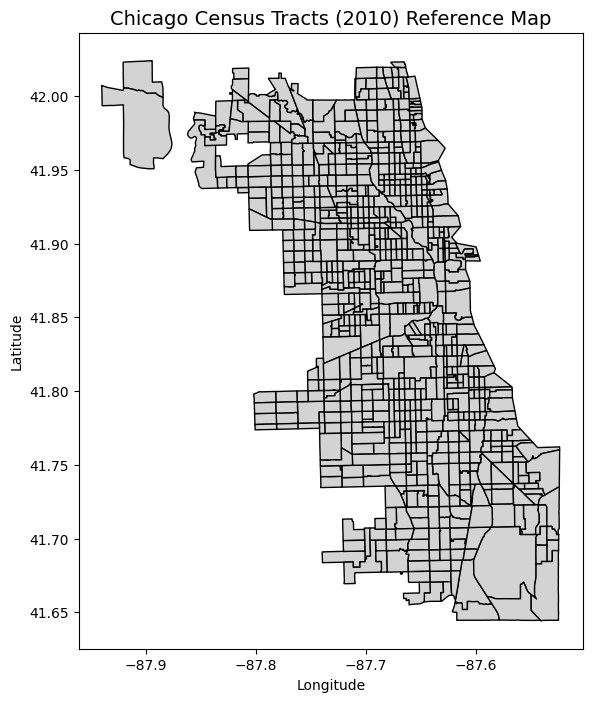

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
chicago_tracts_2010.plot(ax=ax, edgecolor='black', facecolor='lightgray')
ax.set_title("Chicago Census Tracts (2010) Reference Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [14]:
chicago_tracts_2010 = chicago_tracts_2010.rename(columns={"geoid10":"tract_id"})
chicago_tracts_2010.head()

,statefp10,countyfp10,tractce10,tract_id,name10,namelsad10,commarea,commarea_n,notes,geometry,latitude,longitude
0,17,031,842400,17031842400,8424,Census Tract 8424,44,44.0,None,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",41.742475,-87.630040
1,17,031,840300,17031840300,8403,Census Tract 8403,59,59.0,None,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",41.832094,-87.681882
2,17,031,841100,17031841100,8411,Census Tract 8411,34,34.0,None,"POLYGON ((-87.62935 41.8528, -87.62934 41.8525...",41.851006,-87.635098
3,17,031,841200,17031841200,8412,Census Tract 8412,31,31.0,None,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",41.855562,-87.683342
4,17,031,839000,17031839000,8390,Census Tract 8390,32,32.0,None,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",41.871044,-87.631405


In [15]:
def get_weather_data_2010_tracts(row, save_dir="weather_data_2010tracts", force_update=False):
    '''Script to get past month weather data for each tract in Chicago as per the 2020 Census data. \nReturns a dataframe. '''
    
    lat = row["latitude"]
    lon = row["longitude"]
    
    tract_id = row["tract_id"] # this is the tract identifier
    filename = os.path.join(save_dir, f"tract_weather_{tract_id}.parquet") # caching

    if os.path.exists(filename) and not force_update:
        try:
            return pd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read existing data for tract {tract_id}: {e}")

    api_params = {
        "latitude": lat,
        "longitude": lon,
        "timezone": "America/Chicago",
        "start_date": "2025-06-15",
        "end_date": "2025-07-15",
        "hourly": ["temperature_180m", "wind_direction_180m", "wind_speed_180m", "surface_pressure", "cloud_cover", "relative_humidity_2m", "precipitation", "visibility"],
        "wind_speed_unit": "mph",
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch"
    }

    api = "https://api.open-meteo.com/v1/forecast"  

    try:
        time.sleep(0.1)
        response = requests.get(api, params=api_params, timeout=15)
        response.raise_for_status()
        data = response.json()

        if "hourly" not in data:
            raise ValueError(f"No 'hourly' key found: {data}")

        hourly_data = pd.DataFrame(data["hourly"])
        hourly_data["tract_id"] = tract_id

        os.makedirs(save_dir, exist_ok=True)
        hourly_data.to_parquet(filename, index=False)

        return hourly_data

    except Exception as e:
        print(f"Failed for tract {row['tract_id']} at ({lat}, {lon}): {e}")
        return None

In [21]:
def all_tracts_weather_historical():
    '''Get past month weather data for each Chicago tract (2010).'''
    final_csv_data = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(get_weather_data_2010_tracts, row, force_update=False) for _, row in chicago_tracts_2010.iterrows()]
        
        # tdqm progress bar 
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching weather data"):
            result = future.result()
            if result is not None:
                final_csv_data.append(result)

    all_tracts_csv = pd.concat(final_csv_data, ignore_index=True)
    return all_tracts_csv

In [25]:
final_tracts_weather_csv = all_tracts_weather_historical()
final_tracts_weather_csv

Fetching weather data: 100%|██████████| 801/801 [00:01<00:00, 416.42it/s]


,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id
0,2025-06-15T00:00,64.6,56,13.2,997.2,55,84,0.0,52165.355,17031840300
1,2025-06-15T01:00,65.0,57,12.5,996.8,46,86,0.0,51509.188,17031840300
2,2025-06-15T02:00,65.1,61,11.8,996.6,4,84,0.0,53805.773,17031840300
3,2025-06-15T03:00,65.0,60,10.3,996.4,50,88,0.0,48228.348,17031840300
4,2025-06-15T04:00,64.4,53,9.3,996.1,4,84,0.0,54790.027,17031840300
...,...,...,...,...,...,...,...,...,...,...
595939,2025-07-15T19:00,83.9,180,12.8,991.4,100,58,0.0,103674.539,17031630900
595940,2025-07-15T20:00,80.3,187,15.1,991.2,6,58,0.0,103674.539,17031630900
595941,2025-07-15T21:00,79.4,199,14.2,990.7,100,62,0.0,85629.922,17031630900
595942,2025-07-15T22:00,78.1,196,15.4,991.6,2,76,0.0,65616.797,17031630900


In [23]:
final_tracts_weather_csv["trimmed_time"] = final_tracts_weather_csv["time"].str.slice(0,10)
final_tracts_weather_csv["cleaned_time"] = pd.to_datetime(final_tracts_weather_csv["trimmed_time"])
final_tracts_weather_csv.groupby("cleaned_time").nunique()

,time,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,tract_id,trimmed_time
cleaned_time,,,,,,,,,,,
2025-06-15,24,100,45,110,82,99,51,1,247,801,1
2025-06-16,24,132,99,106,126,100,57,1,330,801,1
2025-06-17,24,164,67,110,93,91,65,1,352,801,1
2025-06-18,24,129,157,174,116,75,43,133,234,801,1
2025-06-19,24,144,64,101,133,93,63,49,331,801,1
2025-06-20,24,92,70,136,103,96,48,2,279,801,1
2025-06-21,24,139,28,125,89,77,40,1,232,801,1
2025-06-22,24,118,24,125,104,57,47,1,265,801,1
2025-06-23,24,121,28,116,97,53,51,1,307,801,1


In [24]:
agg_weather_data = final_tracts_weather_csv.drop(columns=["time","trimmed_time"]).groupby(["cleaned_time","tract_id"]).agg("mean").reset_index()
df_merged = agg_weather_data.merge(chicago_tracts_2010, on="tract_id", how="inner")
df_merged.shape

(24831, 21)

In [29]:
df_merged.tract_id.nunique() # we get all 801 expected "tract_id"s

801

In [30]:
df_merged.to_csv("per-census-agg-weather-data.csv", index=False)